# CS-6570 Assignment #4 - Logistic Regression

**YOUR NAME HERE**

*Weber State University*

For this asignment we're going to use logistic regression to attempt to predict which of the passengers on the Titanic will live and which will not. 

For reference, the RMS Titanic was a British passenger liner which sank in the North Atlantic Ocean on April 15th, 1912 after striking an iceberg during its maiden voyage from Southampton, England to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time, and it remains the deadliest sinking of an ocean liner or cruise ship.

It was also notable because there were quite a few hours between when the ship struck the iceberg and when it went under, and most of those who survived did so by boarding lifeboats. In other words, there was a (noisy and nonuniform) process that determined who would be on the lifeboats and who would not, and this process mostly determined who survived.

For this assignment, we're going to try to predict who survives based upon known passenger information.

*Note* - Whether a passenger was on a floating door isn't one of the variables.

![Titanic Door](TitanicDoor.jpg)

The variables we will have are:

|*Variable* |*Description* |*Details* |
|:----|:----|:----|
|survival|Whether the passenger survived|0 = No, 1 = Yes|
|pclass|The passenger class of the ticket|1 = 1st, 2 = 2nd, 3 = 3rd|
|name| First and last name of the passenger||
|sex|The gender of the passenger||
|age|The age of the passenger||
|sibsp|The number of siblings / spouses on the ship with the passenger||
|parch|The number of parents / children on the ship with the passenger||
|ticket|The ticket number||
|fare|The cost of the ticket||
|embarked|The port of embarcation for the passenger|C = Cherbourg, Q = Queenstown, S = Southampton|

Note that we're using a slightly modified and cleaned version of the commonly available Titanic dataset. Before we import the data, we'll first import our favorite libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data file is named "titanic_train_clean.csv".

In [2]:
#Import the Titanic data
titanic_col_names = ['PassengerID','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked']
titanic = pd.read_csv('Datasets/titanic_train_clean.csv',header=0,names=titanic_col_names)
titanic.head()

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


I'll also import the seaborn data visualization library based on matplotlib, set a couple style parameters, and get rid of some annoying warnings.

In [3]:
import seaborn as sns #Data visualization library based on matplotlib

#Set some style parameters for seaborn
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
#Get rid of some annying warnings
import warnings
warnings.simplefilter(action='ignore')

Have you heard the phrase "women and children first?" Well, it relates to the [code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) that is supposed to be practiced in a life-threatening situation. Let's see if it's a decent predictor on the Titanic. In particulary, let's look at how survival percentage broke down by gender.

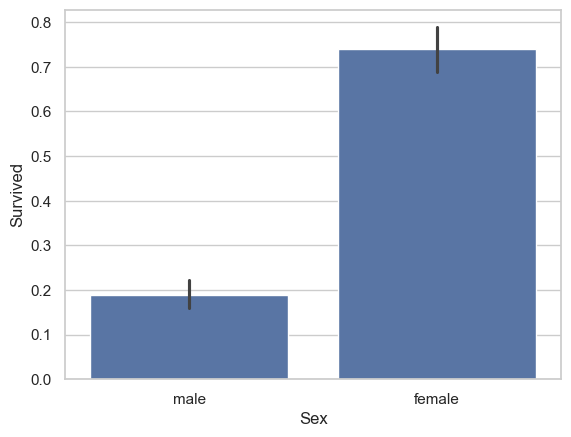

In [4]:
#Examine survival by gender
sns.barplot(x='Sex', y='Survived', data=titanic)
plt.show()

Whoa! Looks like many more men went down with the ship. Now, let's take a look at survival rates based on age, and see how well the "children" aspect of that dictum holds up.

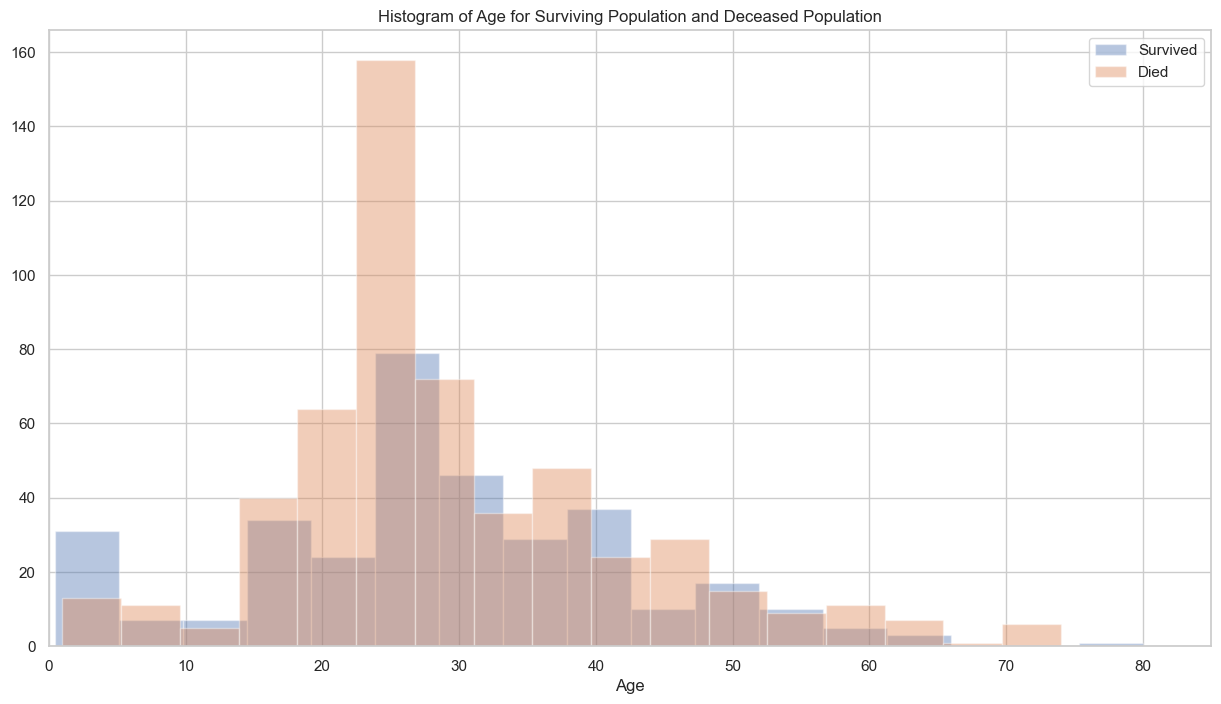

In [5]:
#Survival by age histogram
plt.figure(figsize=(15,8))
ax = sns.distplot(titanic["Age"][titanic.Survived == 1], hist=True, kde=False, bins = 17)
sns.distplot(titanic["Age"][titanic.Survived == 0], hist=True, kde=False, bins = 17)
plt.legend(['Survived', 'Died'])
plt.title('Histogram of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(0,85)
plt.show()

OK, it looks like being a child did make one more likely to survive as well. Let's see if we can build a logistic regression model based on this dictum. In other words, just using age and gender as our predictive variables.

First, we'll import some function we'll need from sklearn.

In [6]:
#from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

We're going to want to convert our gender data column into a numeric one. So, we'll create a dummy "male" variable.

In [7]:
#Create a dummy "male" variable
#WARNING - If you run this twice, you'll create two distinct dummy variable columns
gender = pd.get_dummies(titanic["Sex"],drop_first=True)
port = pd.get_dummies(titanic["Embarked"],drop_first=True)

titanic = pd.concat([titanic,gender], axis='columns')
titanic = pd.concat([titanic,port], axis='columns')
titanic['Fare per Year of Age'] = titanic['Fare'] / titanic['Age']
titanic.head()

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S,Fare per Year of Age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,True,False,True,0.329545
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,False,False,False,1.875876
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,False,False,True,0.304808
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,False,False,True,1.517143
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,True,False,True,0.230000


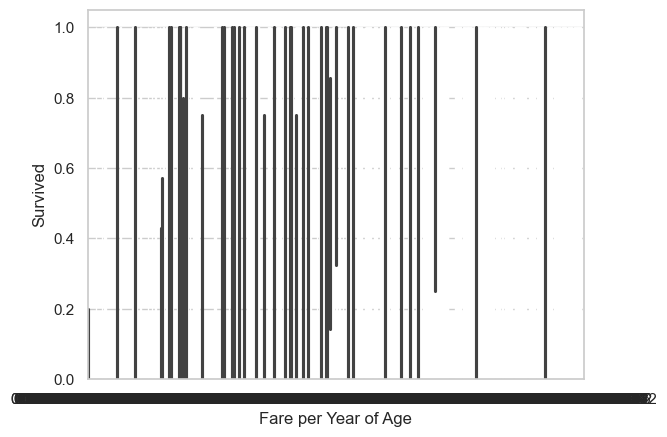

In [8]:
#Examine survival by gender
sns.barplot(x='Fare per Year of Age', y='Survived', data=titanic)
plt.show()

Then we'll create a dependent and independent variable for the logistic regression model.

In [9]:
#Create the dependent and independent variable for the logistic model
# X = titanic[["Age","male"]]
# y = titanic["Survived"]

We'll split our data into a training dataset and a test dataset. 

In [10]:
#Split the data into training data and test data, 75/25
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25,random_state = 1912)

Then, we'll build our logistic regression model.

In [11]:
# #Build the logistic model using the Fare variable
# logmodel = LogisticRegression()
# logmodel.fit(X_train[["Age","male"]],y_train);

Now, we'll use this model to predict survival in the test dataset.

In [12]:
# #Use the model to predict the y values in the test set.
# y_pred = logmodel.predict(X_test[["Age","male"]])
# #Create the confusion matrix
# confusion_matrix(y_test,y_pred)

We can check our accuracy, precision, and recall:

In [13]:
# #Check the accuracy, precision, and recall
# print("Accuracy:",accuracy_score(y_test,y_pred))
# print("Precision:",precision_score(y_test,y_pred))
# print("Recall:",recall_score(y_test,y_pred))

Grab the probabilities for the ROC curve:

In [14]:
# #Get the probabilities for the ROC curve
# pred_prob = logmodel.predict_proba(X_test[["Age","male"]])
# fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1],pos_label=1)

Finally, we can graph the ROC curve and get the AUC score:

In [15]:
# #Graph the ROC curve and display the AUC score
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()
# roc_auc_score(y_test,pred_prob[:,1])

An AUC of .73 isn't great, but it's not terrible. For this assignment, you're going to see if you can do better.

The rules are:

- You need to use a logistic regression model.
- You can only use tha data provided in the dataset, and obviously you can't use "survival" (the variable you want to predict) as a predictor.
- You should build your model on the training data produced above, and test it (ROC curve and AUC score) on the test data produced above.

Do some data exploration, try to figure out a good model, and prove the ROC curve and AUC score for the one you find. Please chart the ROC curve and provide the AUC score as above. Full credit will be awarded if you can find an AUC above .8, and a bonus will go to whoever in the class can produce the best model as measured by AUC score on the test dataset.

*Hint* - It helps to be rich.

In [16]:
#Your work here.
#Build the logistic model using the Fare variable
titanic

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S,Fare per Year of Age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,True,False,True,0.329545
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,False,False,False,1.875876
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,False,False,True,0.304808
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,False,False,True,1.517143
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,True,False,True,0.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,True,False,True,0.481481
885,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,False,False,True,1.578947
886,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,25.0,1,2,W./C. 6607,23.4500,S,False,False,True,0.938000
887,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,True,False,False,1.153846


When to One-Hot Encode vs Label Encode?

```To prevent biases from being introduced, One-Hot Encoding is preferable for nominal data (where there is no inherent order among categories). Label encoding, however, might be more appropriate for ordinal data (where categories naturally have an order)```

So we should one-hot encode columns like Sex, Embarked

**https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/**

In [17]:
def Preprocessing(df, columns_to_one_hot_encode, columns_to_label_encode, columns_to_scale):

    def OneHotEncode (df, columns_to_one_hot_encode):
        from sklearn.preprocessing import OneHotEncoder
        onehotencode = OneHotEncoder()      

        for item in columns_to_one_hot_encode:
            df[item] = df[item].astype('category') # Must convert the strings to category numbers for One Hot to work
            df[item + '_new'] = df[item].cat.codes # Rob: Need to research this more
            # print(f" Column: {item}")
            # print(df[item + '_new'])

        OneHot_df = pd.DataFrame(onehotencode.fit_transform(df[columns_to_one_hot_encode]).toarray())

        PostOneHot_df = df.join(OneHot_df) # Appends the OneHot_df to the original dataframe to create a new one
        PostOneHot_df[:-100] # Check results from the One Hot Encoding
        PostOneHot_df = PostOneHot_df.drop(columns=columns_to_one_hot_encode)
        df = PostOneHot_df
        return df

    def StripSpaces (df):
        # I noticed some of the columns get imported with leading spaces. I want to strip() these right away
        for column in df.select_dtypes(include=object): # Only review the columns with a str datatype
            df[column] = df[column].apply(lambda x: x.strip())
        return df
    
    def PreLabelEncode(df):
        #   Before label encoding we want to apply some value judgements to the data to give the resulting 
        #   labels some ranking education
        return df

    def LabelEncode(df, columns_to_label_encode):
        from sklearn.preprocessing import LabelEncoder
        LabelEncode = LabelEncoder()

        for item in columns_to_label_encode:
            df[item]= LabelEncode.fit_transform(df[item])
            # print(f"Post Label Encoding for {item}: {df[item].unique()}")

        return df
    
    def StandardScale(df, columns_to_scale):
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()

        scaled_columns = scaler.fit_transform(df[columns_to_scale])
        df[columns_to_scale] = scaled_columns

        return df
    
    df = StripSpaces(df)
    df = OneHotEncode(df, columns_to_one_hot_encode)
    df = PreLabelEncode(df)
    df = LabelEncode(df, columns_to_label_encode)
    df = StandardScale(df, columns_to_scale)
    
    return(df)


In [18]:
# df_train = df_train.drop(columns='CLASS')

columns_to_one_hot_encode = []
columns_to_label_encode = []
columns_to_scale = ['Fare', 'Fare per Year of Age']

titanic = Preprocessing(titanic, columns_to_one_hot_encode, columns_to_label_encode, columns_to_scale)

# print(f"df_train.info(): {df_train.info()} vs df_test.info(): {df_test.info()}")

In [19]:
#Define the variables we'll be using for predictions.
# predictors = ['Pclass','Age','SibSp','Parch','Fare', 'Embarked','male']
predictors = list(titanic.columns.values)
predictors.remove("PassengerID")
predictors.remove("Sex")
predictors.remove("Survived")
predictors.remove("Name")
predictors.remove("Ticket")
predictors.remove("Embarked")

#Define the variable we'll be predicting.
target = 'Survived'

predictors

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'male',
 'Q',
 'S',
 'Fare per Year of Age']

In [20]:
#Create the dependent and independent variable for the logistic model
X = titanic[predictors]
y = titanic[target]

#Split the data into training data and test data, 75/25
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25,random_state = 1912)
y_train

703    0
662    0
82     0
240    1
227    0
      ..
294    0
79     0
859    0
32     1
763    0
Name: Survived, Length: 666, dtype: int64

In [21]:
def fit_log_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values

    #Build the logistic model
    logmodel = LogisticRegression()
    logmodel.fit(X,Y) # Let the search for best parameters change what is searched

    #Use the model to predict the y values in the test set.
    y_pred = logmodel.predict(X)

    #Get the probabilities for the ROC curve
    pred_prob = logmodel.predict_proba(X)
    auc = roc_auc_score(Y,pred_prob[:,1])
    print(f"AUC: {auc}")

    return auc

In [22]:
import itertools

#Initialization variables
Y = y_train
X = X_train

AUC_list, feature_list, numb_features = [],[], []

#Looping over the features in X
for k in range(1,len(X.columns) + 1):
    #Looping over all possible combinations: from 9 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_log_reg(X[list(combo)],Y)   #Store temp result 
        AUC_list.append(tmp_result)                  #Append lists
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'AUC': AUC_list, 'features':feature_list})

AUC: 0.6863906728771594
AUC: 0.5010767172929335
AUC: 0.45944997296348644
AUC: 0.5630804549723468
AUC: 0.6959957500498041
AUC: 0.7713232713232713
AUC: 0.5033345033345034
AUC: 0.573008073008073
AUC: 0.7050553537040024
AUC: 0.7173688254769336
AUC: 0.6787398138749491
AUC: 0.7003737679413353
AUC: 0.7113543870300627
AUC: 0.8448104123779798
AUC: 0.7005634978607951
AUC: 0.7182083803705426
AUC: 0.7317835561078804
AUC: 0.5150787853490556
AUC: 0.5353466839953327
AUC: 0.6884682154952424
AUC: 0.778523521766765
AUC: 0.512493715196418
AUC: 0.5705890165349625
AUC: 0.6626554599527572
AUC: 0.5577158414996253
AUC: 0.7030252435657842
AUC: 0.7714323660269604
AUC: 0.4640082342785045
AUC: 0.5517678085245653
AUC: 0.6552038173659794
AUC: 0.6978029275326574
AUC: 0.7635443446254256
AUC: 0.5759156840237921
AUC: 0.6113240302429492
AUC: 0.693600409816626
AUC: 0.8353903218768084
AUC: 0.7035327711003387
AUC: 0.7020054452486884
AUC: 0.711463481733752
AUC: 0.7757487216946677
AUC: 0.7968372022426077
AUC: 0.8352290514452

In [23]:
df_min = df[df.groupby('numb_features')['AUC'].transform(max) == df['AUC']]
display(df_min)

,numb_features,AUC,features
5,1,0.771323,"(male,)"
13,2,0.844810,"(Pclass, male)"
68,3,0.856327,"(Pclass, male, S)"
161,4,0.864813,"(Pclass, SibSp, male, Fare per Year of Age)"
308,5,0.870362,"(Pclass, SibSp, male, S, Fare per Year of Age)"
399,6,0.872155,"(Pclass, Age, SibSp, male, S, Fare per Year of..."
473,7,0.872435,"(Pclass, Age, SibSp, Parch, male, S, Fare per ..."
503,8,0.872539,"(Pclass, Age, SibSp, Parch, Fare, male, S, Far..."
510,9,0.872445,"(Pclass, Age, SibSp, Parch, Fare, male, Q, S, ..."


In [31]:
sorted_df = df.sort_values(by=['AUC'], ascending=False).iloc[0]
best_features = list(sorted_df['features'])
best_features

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'male',
 'S',
 'Fare per Year of Age']

In [32]:
sorted_df

numb_features                                                    8
AUC                                                       0.872539
features         (Pclass, Age, SibSp, Parch, Fare, male, S, Far...
Name: 503, dtype: object

The best AUC I identified using the training data was **0.872539** using 6 features:
('Pclass','Age', 'SibSp', 'Parch', 'Fare', 'male', 'S', 'Fare per Year of Age'

Note: S is one hot encoded column that originated from the embarkation port

Accuracy: 0.7802690582959642
Precision: 0.7222222222222222
Recall: 0.6419753086419753


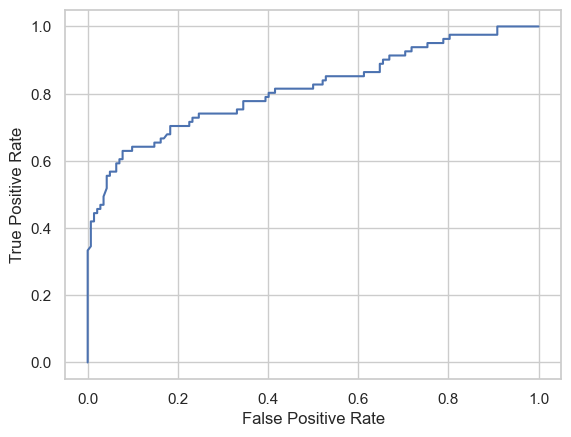

0.814206225004347

In [35]:
#Train the model using the best features
logmodel = LogisticRegression()
logmodel.fit(X_train[best_features],y_train) # Let the search for best parameters change what is searched


#Use the model to predict the y values in the test set.
y_pred = logmodel.predict(X_test[best_features])
#Create the confusion matrix
confusion_matrix(y_test,y_pred)
#Check the accuracy, precision, and recall
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Recall:",recall_score(y_test,y_pred))
#Get the probabilities for the ROC curve
pred_prob = logmodel.predict_proba(X_test[best_features])
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1],pos_label=1)
#Graph the ROC curve and display the AUC score
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc_score(y_test,pred_prob[:,1])